<a href="https://colab.research.google.com/github/BernardoRicci/Python/blob/main/FNS1_Compton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Effetto Compton

Valerio Ippolito - INFN Sezione di Roma

Vogliamo visualizzare la distribuzione energetica dopo urto elastico su una particella di massa $M$ di fotoni di una certa energia. Gli ingredienti di questo esercizio saranno:
- la nostra ipotesi sulla distribuzione angolare degli urti, cioè sulla distribuzione di $\theta$, angolo di scattering (angolo fra la direzione di volo finale e iniziale del fotone);
- l'equazione che lega l'energia finale del fotone, $E_f$, quella iniziale $E_i$ e l'angolo $\theta$:
$$
E_f = E_i \frac{1}{1+\frac{E_i}{M}(1-\cos\theta)}.
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Definiamo intanto una funzione che ci permette di conoscere l'energia finale di un fotone che diffonde su una particella massiva (effetto Compton), noti la sua energia iniziale e l'angolo a cui viene diffuso:

In [ ]:
def get_Ef(Ei, theta, M):
  return Ei / (1 + Ei/M * (1 - np.cos(theta)))

Generiamo un certo numero di fotoni con una delta di Dirac come  distribuzione energetica, centrata sul valore $E_0$:

In [ ]:
E0 = 500. # keV
Nphotons = 100000

Ei = np.ones(Nphotons) * E0 # sarà un array con 10'000 entries, tutte uguali a E0

**Esercizio**: si cambi la distribuzione energetica, usando ad esempio una distribuzione uniforme in un intervallo finito, oppure una gaussiana. Cosa cambia?

Generiamo in maniera uniforme i valori possibili di $\theta$, e calcoliamo i valori di $E_f$ corrispondenti.  Assumiamo che l'impatto avvenga su una particella di massa $M=511$ keV (un elettrone):

In [ ]:
theta = np.random.uniform(0, 2*np.pi, Nphotons)

M = 511. # keV
 
Ef = get_Ef(Ei, theta, M=M)

Plottiamo l'istogramma dei $\theta$ e delle $E_f$ generati

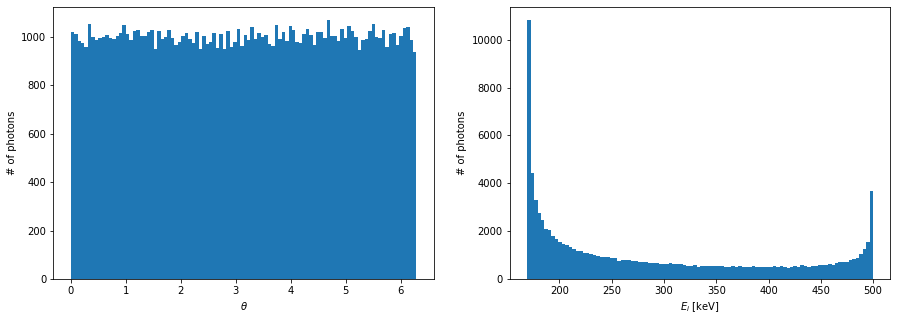

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].hist(theta, bins=100)
ax[0].set_xlabel('$\\theta$')
ax[0].set_ylabel('# of photons')

ax[1].hist(Ef, bins=100)
ax[1].set_xlabel('$E_{i}$ [keV]')
ax[1].set_ylabel('# of photons')

fig.show()

Nella realtà, tuttavia, la distribuzione angolare non sarà uniforme: la sezione d'urto dell'interazione Compton non è infatti isotropa, ma è descritta dalla [formula di Klein-Nishina](https://it.wikipedia.org/wiki/Formula_di_Klein%E2%80%93Nishina).

Per i nostri scopi, possiamo approssimare la distribuzione angolare come
$$
\frac{dN}{d\theta} \propto 1 + \cos^2\theta,
$$
per cui possiamo immaginare di simulare la dinamica dell'interazione non generando una distribuzione piatta in $\theta$, bensì una distribuzione proporzionale a $1+\cos^2\theta$.

Come possiamo fare? Uno dei modi è usare il [metodo dell'inversione](https://it.wikipedia.org/wiki/Metodo_dell%27inversione), o *Inverse transform sampling*, di cui trovate [qui](http://www.cse.psu.edu/~rtc12/CSE586/lectures/cse586samplingPreMCMC.pdf) una buona spiegazione.

Dal nostro punto di vista, si tratta di definire una funzione che inverta la cumulativa di una distribuzione. Nella fattispecie, per noi la distribuzione sarà l'istogramma di una certa quantità ($\theta$, che è un array - l'argomento ```data``` della definizione della funzione qua sotto), interpolato opportunamente (vedi la chiamata a ```interpolate.interp1d```).

In [ ]:
import scipy.interpolate as interpolate # ci serve per interp1d

In [ ]:
def inverse_transform_sampling(data, weights, n_bins=40, n_samples=1000):
    hist, bin_edges = np.histogram(data, weights=weights, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r)

Generiamo ora i nostri $\theta$:
  * creiamo un array, ```thetadist```, che contiene i valori di $1+\cos^2\theta_i$ calcolato su $\theta_i\in[\theta_0=0,\theta_1=\frac{2\pi}{100}\dots\theta_{99}=2\pi]$;
  * usiamo la funzione creata sopra per generare, per ciascuno dei ```len(Ei)``` fotoni, un valore di $\theta$ seguendo un istogramma di ```thetadist```:

In [ ]:
thetas = np.linspace(0, 2*np.pi, 10000) # x della funzione di distribuzione
thetadist = 1 + np.power(np.cos(thetas), 2) # y, cioè il valore della funzione di distribuzione
theta_1pluscos2 = inverse_transform_sampling(thetas, thetadist, n_bins=len(thetas), n_samples=len(Ei))

Plottiamo l'istogramma dell'array $\theta$, per assicurarci che tutto sia andato a buon fine:

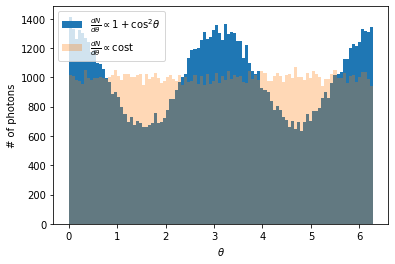

In [ ]:
plt.hist(theta_1pluscos2, bins=100, label='$\\frac{dN}{d\\theta}\\propto 1+\\cos^2{\\theta}$')
plt.hist(theta, bins=100, label='$\\frac{dN}{d\\theta}\\propto \\mathrm{cost}$', alpha=0.3)
plt.xlabel('$\\theta$')
plt.ylabel('# of photons')
plt.legend()
plt.show()

A questo punto, calcoliamo l'energia per questi nuovi eventi (```Ef_1pluscos2```) e plottiamone l'istogramma, confrontandolo con quello ottenuto nel caso di distribuzione piatta di $\theta$:

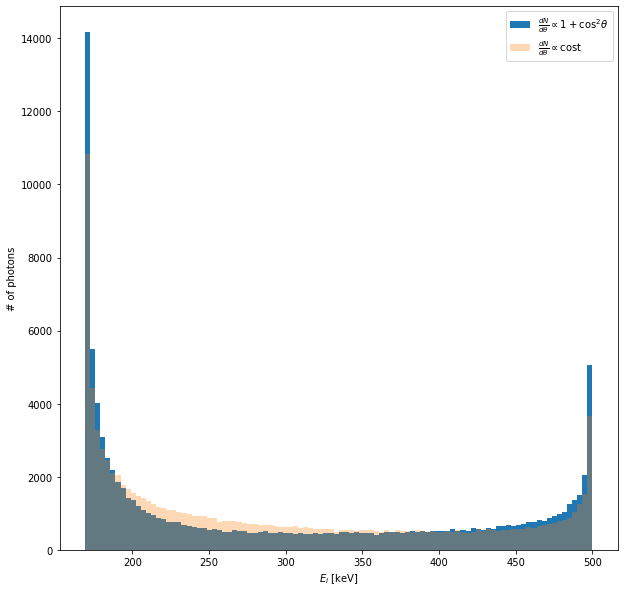

In [ ]:
Ef_1pluscos2 = get_Ef(Ei, theta_1pluscos2, M=M)

fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.hist(Ef_1pluscos2, bins=100, label='$\\frac{dN}{d\\theta}\\propto 1+\\cos^2{\\theta}$')
ax.hist(Ef, bins=100, label='$\\frac{dN}{d\\theta}\\propto \\mathrm{cost}$', alpha=0.3)
ax.set_xlabel('$E_{i}$ [keV]')
ax.set_ylabel('# of photons')
ax.legend()

fig.show()